# Regime Predictor

Rewriting the PCA-based regime projection from the ML and RL in Finance course by Igor Halperin. Theory is based on 
*Principal Components as a Measure of Systemic Risk* by *Mark Kritzman, Yuanzhen Li, Sebastien Page, and Roberto Rigobon*

In [213]:
import glob
import pandas as pd
import numpy as np
import sklearn.decomposition
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 13,8
import seaborn as sns
import pandas as pd

#### Dataset:  daily prices of for market representative such as S&P 500, MSCI World, etc. ####

In [214]:
#use temp.py to obtain individual stock data
path = r'./individual_stocks/' # use your path
all_files = glob.glob(path + "*.csv")

li = []
cols = []
for filename in all_files[:]:
    df = pd.read_csv(filename, index_col=0, header=0, date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'))
    df = df.Close
    cols.append(filename.partition("_")[-1].partition("_")[0].strip("stocks/"))
    li.append(df)
n_stocks_show = 12
frame = pd.concat(li, axis=1, ignore_index=True)
frame = frame.rename(columns=dict(zip(range(len(all_files)), cols)))
asset_prices = frame.interpolate().fillna(method="ffill").fillna(method="bfill")
print('Asset prices shape', asset_prices.shape)
display(asset_prices.iloc[:, :n_stocks_show].head(-3))
asset_prices.index

Asset prices shape (3777, 505)


,GS,SPGI,MTB,V,CTAS,ZBRA,BRO,APH,RHI,HCA,HD,PEP
Date,,,,,,,,,,,,
2007-02-14,217.399994,68.070000,124.029999,14.125000,42.369999,37.970001,14.215000,8.443750,41.330002,31.020000,41.730000,63.349998
2007-02-15,216.820007,67.690002,124.129997,14.125000,42.340000,39.990002,14.335000,8.433750,41.240002,31.020000,41.660000,64.080002
2007-02-16,216.919998,68.580002,124.419998,14.125000,42.389999,40.830002,14.310000,8.372500,41.430000,31.020000,41.439999,64.620003
2007-02-20,220.940002,68.610001,124.739998,14.125000,42.810001,41.080002,14.220000,8.490000,41.180000,31.020000,41.340000,64.610001
2007-02-21,220.149994,68.650002,124.550003,14.125000,42.470001,41.599998,14.140000,8.490000,41.340000,31.020000,41.299999,65.019997
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-02,363.059998,422.070007,175.820007,235.419998,391.450012,517.010010,68.080002,80.449997,117.000000,240.789993,373.730011,175.470001
2022-02-03,358.880005,413.149994,175.179993,231.539993,385.079987,508.299988,66.639999,79.070000,116.059998,240.860001,364.809998,175.369995
2022-02-04,367.600006,414.390015,179.559998,228.389999,381.809998,503.089996,67.529999,78.760002,118.360001,239.080002,359.670013,172.490005


DatetimeIndex(['2007-02-14', '2007-02-15', '2007-02-16', '2007-02-20',
               '2007-02-21', '2007-02-22', '2007-02-23', '2007-02-26',
               '2007-02-27', '2007-02-28',
               ...
               '2022-01-31', '2022-02-01', '2022-02-02', '2022-02-03',
               '2022-02-04', '2022-02-07', '2022-02-08', '2022-02-09',
               '2022-02-10', '2022-02-11'],
              dtype='datetime64[ns]', name='Date', length=3777, freq=None)

### Calculate daily log-returns

In [236]:
asset_returns = np.log(asset_prices) - np.log(asset_prices.shift(1))
#asset_returns = asset_prices.pct_change(periods=1) #log(1+r) approx r
asset_returns = asset_returns.iloc[1:, :]
asset_returns.iloc[:, :n_stocks_show].head()

,GS,SPGI,MTB,V,CTAS,ZBRA,BRO,APH,RHI,HCA,HD,PEP
Date,,,,,,,,,,,,
2007-02-15,-0.002671,-0.005598,0.000806,0.0,-0.000708,0.051833,0.008406,-0.001185,-0.002180,0.0,-0.001679,0.011457
2007-02-16,0.000461,0.013062,0.002334,0.0,0.001180,0.020788,-0.001745,-0.007289,0.004597,0.0,-0.005295,0.008392
2007-02-20,0.018363,0.000437,0.002569,0.0,0.009859,0.006104,-0.006309,0.013936,-0.006053,0.0,-0.002416,-0.000155
2007-02-21,-0.003582,0.000583,-0.001524,0.0,-0.007974,0.012579,-0.005642,0.000000,0.003878,0.0,-0.000968,0.006326
2007-02-22,-0.005374,-0.011722,-0.002492,0.0,0.003760,0.001201,0.001766,-0.001916,0.006750,0.0,-0.002910,-0.005552


In [237]:
def normalize_returns(df):
    """
    Normalize, i.e. center and divide by standard deviation raw asset returns data

    Arguments:
    r_df -- a pandas.DataFrame of asset returns

    Return:
    normed_df -- normalized returns
    """
    return (df - df.mean(axis=0))/df.std(axis=0)

In [238]:
normed_r = normalize_returns(asset_returns)
display(normed_r.iloc[:, :n_stocks_show].head(-3))
#easier than standardscaler from sklearn

,GS,SPGI,MTB,V,CTAS,ZBRA,BRO,APH,RHI,HCA,HD,PEP
Date,,,,,,,,,,,,
2007-02-15,-0.118458,-0.296378,0.030597,-0.040134,-0.074029,2.301105,0.520002,-0.093296,-0.114579,-0.029045,-0.131516,0.939962
2007-02-16,0.013725,0.616442,0.096998,-0.040134,0.034673,0.905360,-0.140190,-0.416109,0.200503,-0.029045,-0.343604,0.682626
2007-02-20,0.769126,-0.001143,0.107216,-0.040134,0.534249,0.245220,-0.436976,0.706421,-0.294639,-0.029045,-0.174752,-0.034750
2007-02-21,-0.156886,0.005975,-0.070689,-0.040134,-0.492239,0.536299,-0.393573,-0.030623,0.167086,-0.029045,-0.089827,0.509208
2007-02-22,-0.232517,-0.595932,-0.112757,-0.040134,0.183185,0.024790,0.088197,-0.131943,0.300641,-0.029045,-0.203712,-0.487785
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-02,-0.121799,0.514695,0.736090,0.676485,0.577264,0.630393,1.334339,0.850997,0.954524,0.750678,0.761712,1.489035
2022-02-03,-0.494381,-1.067428,-0.162948,-0.950394,-0.977648,-0.793077,-1.416964,-0.945678,-0.388287,-0.013385,-1.449914,-0.069610
2022-02-04,1.007322,0.124063,1.068994,-0.790421,-0.524138,-0.492410,0.836096,-0.238374,0.899199,-0.428649,-0.865307,-1.411666


Now we compute the Absorption Ratio(AR) by taking a moving window of the returns for which we compute the covariance matrix and do a PCA. The data is based on step_size (business daily, ...) Then we look, how much variation of the complete market is determined already by 1/5 of the constitutents.

In [239]:
def absorption_ratio(explained_variance, n_components):
    """
    Calculate absorption ratio via PCA.
    
    Arguments:
    explained_variance -- 1D np.array of explained variance by each pricincipal component, in descending order
    n_components -- an integer, a number of principal components to compute absorption ratio
    Return:
    ar -- absorption ratio
    """
    ar = np.sum(explained_variance[:n_components]) / np.sum(explained_variance)
    return ar

In [291]:
stock_tickers = asset_returns.columns.values[:-1]

lookback_window = 252 * 2   # in (days)
num_assets = len(stock_tickers)
step_size = 1          # days : 5 - weekly, 21 - monthly, 63 - quarterly

# fix 20% of principal components for absorption ratio calculation. How much variance do they explain?
absorb_comp = int((1. / 5) * num_assets)  

print('Lookback window = %d' % lookback_window)
print('Step size = %d' % step_size)
print('Number of stocks = %d' % num_assets)
print('Number of principal components = %d' % absorb_comp)

# indexes date on which to compute PCA
days_offset = 4 * 252
num_days = 12 * 252 + days_offset
pca_ts_index = normed_r.index[list(range(lookback_window + days_offset, min(num_days, len(normed_r)), step_size))]

# allocate array for storing absorption ratio
absorp_ratio = np.array([np.nan]*len(pca_ts_index))

assert 'SPX' not in normed_r.iloc[:lookback_window, :-1].columns.values, "By accident included SPX index"

Lookback window = 504
Step size = 1
Number of stocks = 504
Number of principal components = 100


In [292]:
#%%timeit
ik = 0
print(range(lookback_window + days_offset, min(num_days, len(normed_r)), step_size))
for ix in range(lookback_window + days_offset, min(num_days, len(normed_r)), step_size):
    ret_frame = normed_r.iloc[(ix - lookback_window) : ix, :-1]  # fixed window
    cov_mat = ret_frame.cov()
    if ik == 0 or ik % 21 == 0: # to speed up convergence compute just once a month?
        pca = sklearn.decomposition.PCA() #restrict to n_components=absorb_comp and rely on the ratio
        pca.fit(cov_mat)
        #absorp_ratio[ik]= pca.explained_variance_ratio_.sum()
        absorp_ratio[ik] = absorption_ratio(pca.explained_variance_, absorb_comp) 
    else:
        absorp_ratio[ik] = absorp_ratio[ik-1]
    ik += 1

ts_absorb_ratio = pd.Series(absorp_ratio, index=pca_ts_index)

range(1512, 3776)


Text(0.5, 1.0, 'Absorption Ratio via PCA')

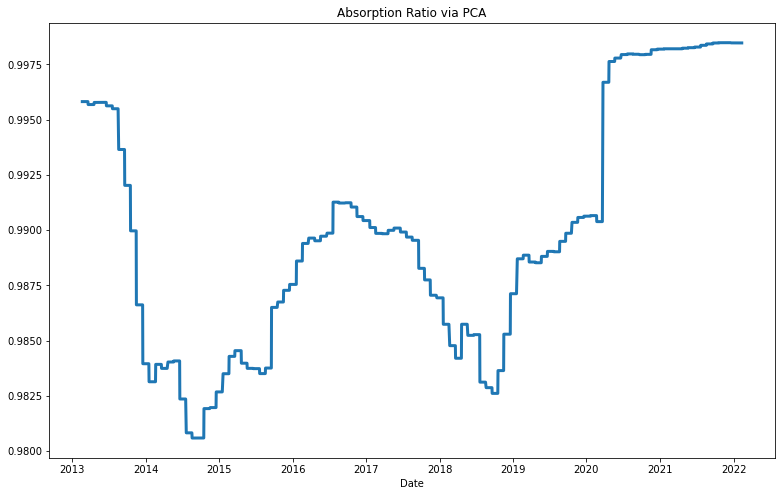

In [293]:
#how much variance do the fix 20% of principal components explain?
sns.lineplot(data=ts_absorb_ratio, linewidth=3)
plt.title('Absorption Ratio via PCA')
#plt.savefig("Absorption_Ratio_SPX.png", dpi=900)

## Deriving a trading strategy from the absorption ratio according to the Kritzman paper
Having computed daily (this means the step size is 1) Absorption Ratio times series, we further follow M. Kritzman to make use of AR to define yet another measure: AR Delta. In particular:
$$ AR\delta = \frac{AR_{15d} - AR_{1y}}{ AR\sigma_{1y}}$$
We use  $AR\delta$ to build simple portfolio trading strategy

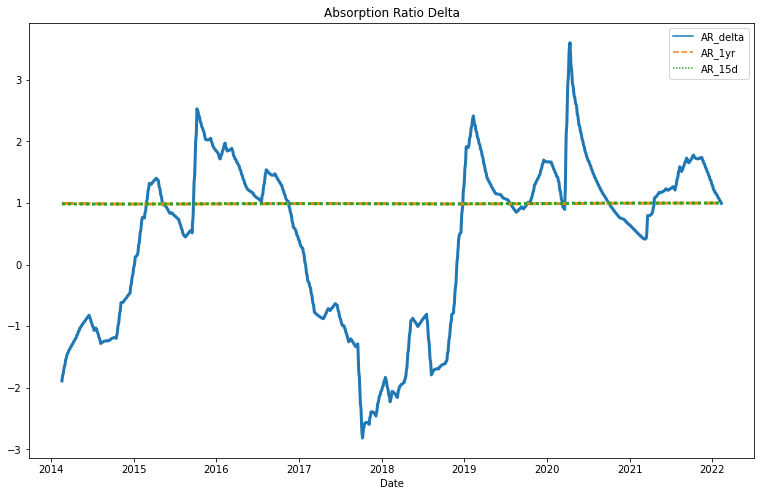

In [294]:
# following Kritzman and computing AR_delta = (15d_AR -1yr_AR) / sigma_AR
ts_ar = ts_absorb_ratio
ar_mean_1yr = ts_ar.rolling(window=252).mean()
ar_mean_15d = ts_ar.rolling(window=15).mean()
ar_sd_1yr = ts_ar.rolling(window=252).std()
ar_delta = (ar_mean_15d - ar_mean_1yr) / ar_sd_1yr    # standardized shift in absorption ratio

df_plot = pd.DataFrame({'AR_delta': ar_delta.values, 'AR_1yr': ar_mean_1yr.values, 'AR_15d': ar_mean_15d.values}, 
                       index=ts_ar.index)
df_plot = df_plot.dropna()
if df_plot.shape[0] > 0:
    sns.lineplot(data=df_plot, linewidth=3)
    plt.title("Absorption Ratio Delta")

#### Part 3 (AR Delta Trading Strategy)

The AR Delta trading strategy forms a portfolio of EQ and FI, following these simple rules:

* __$ -1\sigma < AR < +1\sigma $__	 50 / 50 weights for EQ / FI
* __$ AR > +1\sigma $__	             0 / 100 weights for EQ / FI
* __$ AR < -1\sigma $__	             100 / 0 weights for EQ / FI

Here we compute AR Delta strategy weights using data from the same data set. As expected, the average number of trades per year is very low.

In [309]:
def get_weight(ar_delta):
    '''
    Calculate EQ / FI portfolio weights based on Absorption Ratio delta
    Arguments:
    ar_delta -- Absorption Ratio delta
    
    Return: 
        wgts -- a vector of portfolio weights
    '''
    if ar_delta > 1: return [.0,1.0]
    if ar_delta < -1: return [1.0, .0]
    return [0.5, 0.5]

In [310]:
ar_delta_data = ar_delta[251:]

rebal_dates = np.zeros(len(ar_delta_data))
wgts = pd.DataFrame(data=np.zeros((len(ar_delta_data.index), 2)), index=ar_delta_data.index, columns=('EQ', 'FI'))

prtf_wgts = get_weight(ar_delta_data.values[0])
wgts.iloc[0, :] = prtf_wgts
for ix in range(1, len(ar_delta_data)):
    prtf_wgts = get_weight(ar_delta_data.values[ix])
    wgts.iloc[ix, :] = prtf_wgts
    if wgts.iloc[ix-1, :][0] != prtf_wgts[0]:
        rebal_dates[ix] = 1

ts_rebal_dates = pd.Series(rebal_dates, index=ar_delta_data.index)
ts_trades_per_year = ts_rebal_dates.groupby([ts_rebal_dates.index.year]).sum()
print('Average number of trades per year %.2f' % ts_trades_per_year.mean())
display(wgts.tail())

Average number of trades per year 2.33


,EQ,FI
Date,,
2022-02-07,0.0,1.0
2022-02-08,0.0,1.0
2022-02-09,0.0,1.0
2022-02-10,0.0,1.0
2022-02-11,0.5,0.5


,EQ,FI
Date,,
2014-02-18,1.0,0.0
2014-02-19,1.0,0.0
2014-02-20,1.0,0.0
2014-02-21,1.0,0.0
2014-02-24,1.0,0.0
...,...,...
2022-02-07,0.0,1.0
2022-02-08,0.0,1.0
2022-02-09,0.0,1.0


<AxesSubplot:xlabel='Date', ylabel='EQ'>

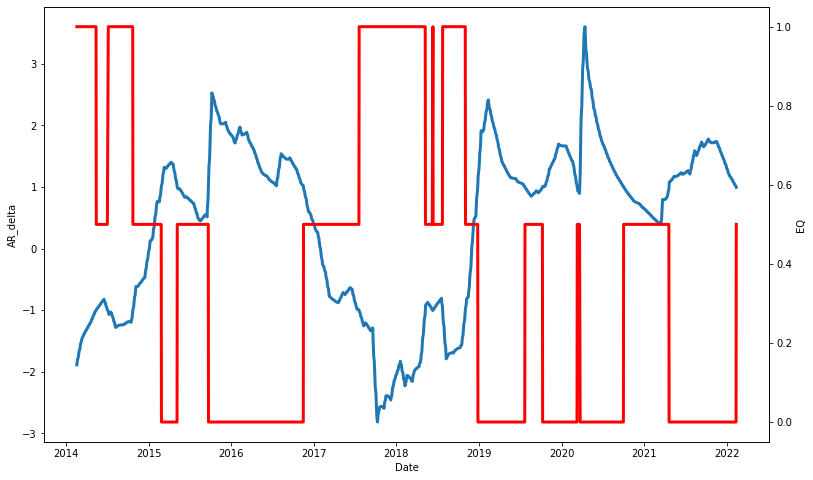

In [319]:
sns.lineplot(data=df_plot.AR_delta, linewidth=3)
ax=plt.twinx()
sns.lineplot(data=wgts.EQ, ax=ax, linewidth=3, color="r")

In [311]:
#use temp.py to obtain individual stock data
all_files = ["./VOO_data.csv", "./GOVT_data.csv"]

li = []
cols = []
for filename in all_files[:]:
    df = pd.read_csv(filename, index_col=0, header=0, date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'))
    df = df.Close
    cols.append(filename.partition("_")[0].strip("./"))
    li.append(df)
n_stocks_show = 12
frame = pd.concat(li, axis=1, ignore_index=True)
frame = frame.rename(columns=dict(zip(range(len(all_files)), cols)))
etf_prices = frame.interpolate().fillna(method="ffill").fillna(method="bfill")
print('Asset prices shape', etf_prices.shape)
display(etf_prices.iloc[:, :].head(-3))
etf_prices.rename({"VOO":"EQ_RETURN", "GOVT":"FI_RETURN"}, axis=1, inplace=True) #still only prices, but column name gets reused

Asset prices shape (2878, 2)


,VOO,GOVT
Date,,
2010-09-09,101.320000,24.820000
2010-09-10,101.779999,24.820000
2010-09-13,103.059998,24.820000
2010-09-14,103.040001,24.820000
2010-09-15,103.300003,24.820000
...,...,...
2022-02-02,420.359985,25.950001
2022-02-03,410.589996,25.870001
2022-02-04,412.519989,25.709999


In [312]:
etf_r = np.log(etf_prices) - np.log(etf_prices.shift(1))
#etf_r = etf_prices.pct_change(periods=1) #log(1+r) approx r
etf_r = etf_r.iloc[1:, :]
etf_r.iloc[:, :].head()

,EQ_RETURN,FI_RETURN
Date,,
2010-09-10,0.004530,0.0
2010-09-13,0.012498,0.0
2010-09-14,-0.000194,0.0
2010-09-15,0.002520,0.0
2010-09-16,-0.000387,0.0


#### Calculate performance of backtested strategy


In [313]:
def backtest_strategy(strat_wgts, asset_returns, periods_per_year = 252):
    '''
    Calculate portfolio returns and return portfolio strategy performance
    Arguments:
    
    strat_wgts -- pandas.DataFrame of weights of the assets
    asset_returns -- pandas.DataFrame of asset returns
    periods_per_year -- number of return observations per year
    
    Return: 
        (ann_ret, ann_vol, sharpe) -- a tuple of (annualized return, annualized volatility, sharpe ratio)
    '''
    
    together = pd.merge(strat_wgts, asset_returns, left_index=True, right_index=True)
    together["Returns"] = together["EQ"]*together["EQ_RETURN"]+together["FI"]*together["FI_RETURN"]
    annualized_return = np.prod(together.Returns.values + 1)**(periods_per_year/len(together.Returns))-1
    annualized_volatility = together.Returns.std() * np.sqrt(periods_per_year)
    return annualized_return, annualized_volatility, annualized_return/annualized_volatility

In [314]:
offset = "01-01-2015"
ann_ret, ann_vol, sharpe = backtest_strategy(wgts[offset:], etf_r[offset:])
print('Absorption Ratio strategy:', ann_ret, ann_vol, sharpe)
eq_wgts = wgts.copy()
eq_wgts.iloc[:, ] = 0.5
ann_ret_eq_wgt, ann_vol_eq_wgt, sharpe_eq_wgt = backtest_strategy(eq_wgts, etf_r)
print('Equally weighted:', ann_ret_eq_wgt, ann_vol_eq_wgt, sharpe_eq_wgt)

Absorption Ratio strategy: 0.014505816548762374 0.08197431899430223 0.17695562130587053
Equally weighted: 0.055647207695751044 0.08143424593537152 0.6833391413719753


## show graphicaly the regimes and sp500

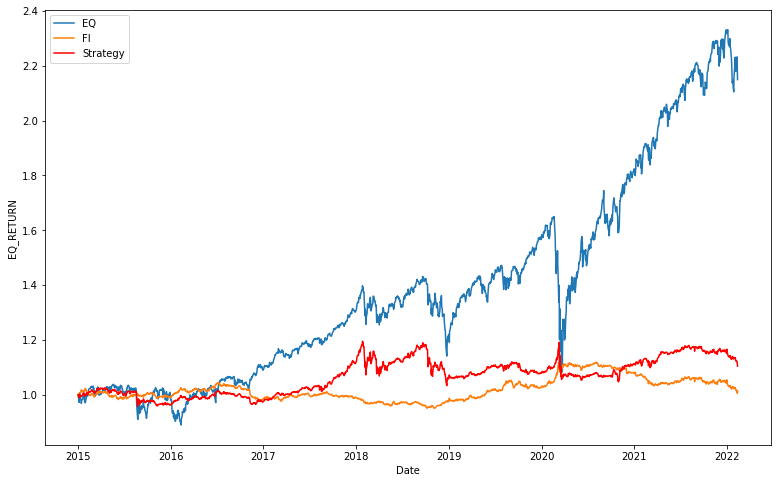

In [315]:
port_r = wgts.EQ * etf_r.EQ_RETURN + wgts.FI * etf_r.FI_RETURN
port_r = port_r[offset:]
port_perform = np.cumprod(1+port_r)
port_perform /= port_perform[0]

EQ_perform = etf_prices.EQ_RETURN[offset:]
EQ_perform /= EQ_perform[0]

FI_perform = etf_prices.FI_RETURN[offset:]
FI_perform /= FI_perform[0]



sns.lineplot(data=EQ_perform, label="EQ")
sns.lineplot(data=FI_perform, label="FI")
sns.lineplot(data=port_perform, color="r", label="Strategy")
plt.legend()

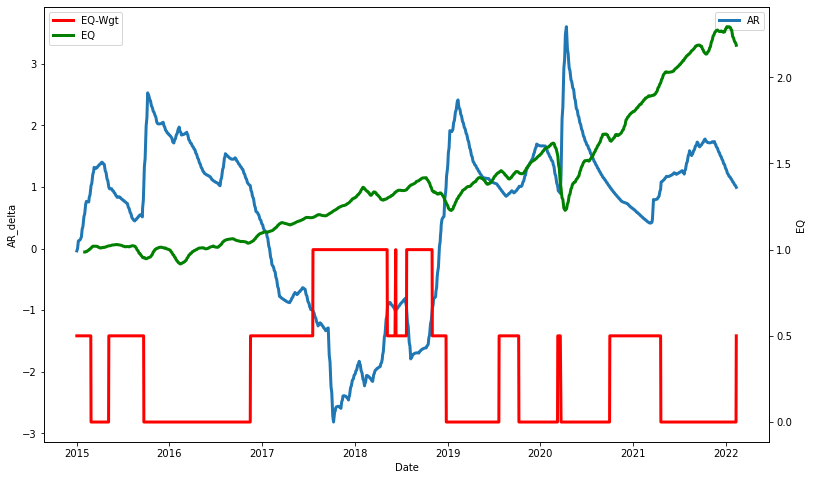

In [326]:
sns.lineplot(data=df_plot.AR_delta[offset:], linewidth=3, label="AR")
ax=plt.twinx()
sns.lineplot(data=wgts.EQ[offset:], ax=ax, linewidth=3, color="r", label="EQ-Wgt")
sns.lineplot(data=EQ_perform.rolling(21).mean(), label="EQ", color="g", linewidth=3)
plt.legend()